In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import math
import os
# Use PrettyTensor to simplify Neural Network construction.
#import prettytensor as pt

In [2]:
import cifar10

In [3]:
# cifar10.data_path = "data/CIFAR-10/"

In [4]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Load the class-names.

In [5]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Load the training-set. This returns the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In [6]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


Load the test-set.

In [7]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [8]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


In [9]:
from cifar10 import img_size, num_channels, num_classes
print("Image size:" , img_size)
print("Number of channels:" , num_channels)
print("Number of classes:" , num_classes)

Image size: 32
Number of channels: 3
Number of classes: 10


In [10]:
def var(name, shape, init=None, std=None):
    if init is None:
        if std is None:
            std = (2./shape[0])**0.5
        init = tf.truncated_normal_initializer(stddev=std)
    return tf.get_variable(name=name, shape=shape, 
                           dtype=tf.float32, initializer=init)

def conv(X, f, strides=[1, 1, 1, 1], padding='SAME'):
    return tf.nn.conv2d(X, f, strides, padding)

def max_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'):
    return tf.nn.max_pool(X, ksize, strides, padding)

In [11]:
g = tf.Graph()
with g.as_default():
    X = tf.placeholder(dtype=tf.float32, shape=[None, img_size,img_size,num_channels], name='x')
    
    Y = tf.placeholder(dtype=tf.float32, shape=[None, num_classes], name='y_true')
    I = tf.reshape(X, [-1, img_size,img_size, num_channels])
    
    
    #Conv Layer 1
    W1 = var('W1', [5,5, 3, 64])
    b1 = var('b1', [64])
    out1 = tf.nn.relu(conv(I, W1) + b1)
    out1 = max_pool(out1)
    
    #Conv Layer 2
    W2 = var('W2', [5,5, 64, 128])
    b2 = var('b2', [128])
    out2 = tf.nn.relu(conv(out1, W2) + b2)
    out2 = max_pool(out2)
    
    #Conv Layer 3
    W3 = var('W3', [5,5, 128, 256])
    b3 = var('b3', [256])
    out3 = tf.nn.relu(conv(out2, W3) + b3)
    out3 = max_pool(out3)
    
    #Conv Layer 4
    W4 = var('W4', [5,5, 256, 128])
    b4 = var('b4', [128])
    out4 = tf.nn.relu(conv(out3, W4) + b4)
    out4 = max_pool(out4)
    
    
    
    flatten = tf.reshape(out4, [-1, 2*2*128])
    
    #Fully Connected Layer
    W5 = var('W5',[2*2*128, 128])
    b5 = var('b5',[128])
    out5 = tf.nn.relu( tf.matmul(flatten ,W5) + b5 )
    
    # Output layer
    W6 = var('W6',[128,10])
    b6 = var('b6',[10])
    logits = tf.matmul(out5, W6) + b6
    
    
    
    pred = tf.argmax(logits, axis=1)
    truth = tf.argmax(Y, axis=1)
    acc = tf.reduce_mean(
    tf.cast(tf.equal(pred,truth),tf.float32))
    
    s_loss = tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=Y)
    loss = tf.reduce_mean(s_loss)
    
    weights = tf.trainable_variables()
    
    #l2_regularizer = tf.nn.l2_loss(weights)
    l2_regularizer =  tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) + tf.nn.l2_loss(W4)+ tf.nn.l2_loss(W5)+ tf.nn.l2_loss(W6)
    loss = tf.reduce_mean(loss + 0.01 * l2_regularizer)
    
    
    
    
    #L1
    #l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.05)
    #regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)
    #regularized_loss = loss + regularization_penalty # this loss needs to be minimized
    
    
    
    step = tf.train.AdamOptimizer().minimize(loss)
    
    #l1_regularizer = tf.contrib.layers.l1_regularizer()
    
    #regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, W4)
    #regularized_loss = loss + regularization_penalty # this loss needs to be minimized
    




In [12]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

In [13]:
#saver = tf.train.Saver()

sess = tf.InteractiveSession(graph=g)
tf.global_variables_initializer().run()


batch_size = 100
rows =  len(images_train)
num_epochs = 100
iter = int(rows/batch_size)

nonzero_weights=[]
acc_train=[]
acc_test=[]


In [14]:
def run_test():
    
    a = 500
    accuracy = 0
    while a <= 10000:
        accuracy +=sess.run(acc,feed_dict={X:images_test[a-500:a,:,:,:],
                                          Y:labels_test[a-500:a,:]})
        a = a+500


    accuracy = accuracy / 20

    return accuracy

In [15]:
for epoch in range(num_epochs):
    epoch_acc = 0
    epoch_loss = 0
    
    for i in range(iter):
        
        x_batch, y_batch =  random_batch()
        _, l,a,w1,w2,w3,w4 = sess.run([step,loss, acc,W1,W2,W3,W4], feed_dict={X:x_batch, Y:y_batch})
        
        
        
        epoch_acc += a
        epoch_loss += l
        
    
    
    zeroweights = (w1.size + w2.size + w3.size + w4.size) - (np.count_nonzero(w1) + np.count_nonzero(w2) + np.count_nonzero(w3) + np.count_nonzero(w4))
    nonzero_weights.append(zeroweights)
    a_test = run_test()
    acc_train.append(epoch_acc / iter)
    acc_test.append(a_test)
    print("Accuracy for train set in epoch ", epoch+1, ": " , epoch_acc / iter ," || loss : " ,epoch_loss / iter
          ,end='\n')
    print("Accuracy for test set in epoch ", epoch+1, ": " , a_test ,'\n',end='\n')


    #saver.save(sess,'./')
            

Accuracy for train set in epoch  1 :  0.3019400008991361  || loss :  4690.5984125976565
Accuracy for test set in epoch  1 :  0.34100000113248824 

Accuracy for train set in epoch  2 :  0.31274000085145237  || loss :  2914.9715864257814
Accuracy for test set in epoch  2 :  0.10099999979138374 

Accuracy for train set in epoch  3 :  0.10267999976128339  || loss :  2533.7776103515625
Accuracy for test set in epoch  3 :  0.10040000006556511 

Accuracy for train set in epoch  4 :  0.0987400000244379  || loss :  2405.7437451171877
Accuracy for test set in epoch  4 :  0.10030000023543835 

Accuracy for train set in epoch  5 :  0.10111999998614192  || loss :  2276.7524794921874
Accuracy for test set in epoch  5 :  0.10049999952316284 

Accuracy for train set in epoch  6 :  0.10039999994263053  || loss :  2147.08862890625
Accuracy for test set in epoch  6 :  0.10029999986290931 

Accuracy for train set in epoch  7 :  0.10198000001907348  || loss :  2016.6667775878907
Accuracy for test set in ep

Accuracy for train set in epoch  58 :  0.7239000006914139  || loss :  1.2465868883132936
Accuracy for test set in epoch  58 :  0.6989999890327454 

Accuracy for train set in epoch  59 :  0.7187400007247925  || loss :  1.251894716501236
Accuracy for test set in epoch  59 :  0.6950999945402145 

Accuracy for train set in epoch  60 :  0.7259600007534027  || loss :  1.23868439245224
Accuracy for test set in epoch  60 :  0.7074999928474426 

Accuracy for train set in epoch  61 :  0.7261000013351441  || loss :  1.2319184013605118
Accuracy for test set in epoch  61 :  0.6596000045537949 

Accuracy for train set in epoch  62 :  0.723280001282692  || loss :  1.2355168418884277
Accuracy for test set in epoch  62 :  0.6858999937772751 

Accuracy for train set in epoch  63 :  0.7301000006198883  || loss :  1.2271346739530564
Accuracy for test set in epoch  63 :  0.6993000000715256 

Accuracy for train set in epoch  64 :  0.7281000018119812  || loss :  1.2285697877407074
Accuracy for test set in ep

# Graphs

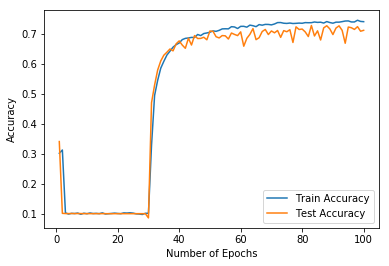

In [16]:
e = np.arange(1,num_epochs+1)
plt.plot(e,acc_train)
plt.plot(e,acc_test)
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')

plt.show()

In [22]:
print("Maximum accuracy reached in the " , np.argmax(acc_test), "th epoch: %",np.amax(acc_test)*100)

Maximum accuracy reached in the  82 th epoch: % 72.88000077009201


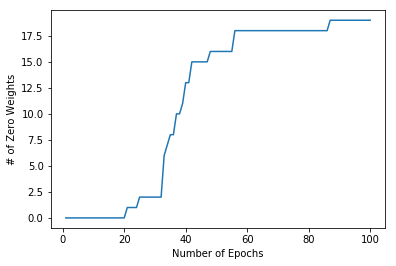

In [17]:
plt.plot(e,nonzero_weights)

plt.xlabel("Number of Epochs")
plt.ylabel("# of Zero Weights")

plt.show()